<a href="https://colab.research.google.com/github/yixliu1/Project-Summary/blob/main/Group_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### The University of Melbourne, School of Computing and Information Systems
# COMP90086 Computer Vision, 2022 Semester 2

## Group Project

## Readin

In [ ]:
import os
from os import listdir
from os.path import isfile, join
import numpy as np
import cv2
import random
import math
import sys
import time
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
#mypath = 'drive/MyDrive/Colab Notebooks/Dataset'
mypath = 'drive/MyDrive/Colab Notebooks/ds'
files = [f for f in listdir(mypath) if isfile(join(mypath, f))]
A_li = [f for f in files if 'left' in f]
B_li = [f for f in files if 'right' in f]
dis_li = [f for f in files if 'disparity' in f]

imgs = []
for i in A_li:
    date = i.split('left')[0]
    r = [x for x in B_li if date in x][0]
    dis = [x for x in dis_li if date in x][0]
    imgs.append([i, r, dis])
len(imgs)

12

(-0.5, 440.5, 199.5, -0.5)

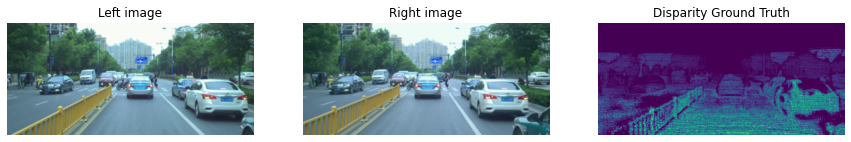

In [ ]:
# load the image
#rootpath='drive/MyDrive/Colab Notebooks/Dataset'
rootpath='drive/MyDrive/Colab Notebooks/ds'

img = imgs[5]
imgL= cv2.pyrDown(cv2.imread(os.path.join(rootpath, img[0]))) 
imgR = cv2.pyrDown(cv2.imread(os.path.join(rootpath, img[1])))

color_imgL = cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB)
color_imgR = cv2.cvtColor(imgR, cv2.COLOR_BGR2RGB)

# the ground truth of disparity image
disparity = cv2.pyrDown(cv2.imread(os.path.join(rootpath, img[2]),flags=cv2.IMREAD_ANYDEPTH))
disparity_value = disparity/256
plt.subplots(figsize=(15, 15)) 

plt.subplot(1,3,1)
plt.imshow(color_imgL)  
plt.title('Left image')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(color_imgR)  
plt.title('Right image')
plt.axis('off')


plt.subplot(1,3,3)
plt.imshow(disparity_value,cmap='viridis') 
plt.title('Disparity Ground Truth')
plt.axis('off')

## Task1:
To calculate a disparity map for the left image using classical (non deep learning) methods. You should create an image of floating point numbers that estimate the disparity (x-x’) for every pixel in the left image.

## Baseline: SSD

In [ ]:
def padding_baseline(img, wid_size):
    jump = int(wid_size//2)
    padding_size = jump*2
    paddingimg = np.zeros((img.shape[0]+padding_size, img.shape[1]+padding_size, img.shape[2]))
    paddingimg[jump:jump+img.shape[0],jump:jump+img.shape[1]] = img

    return paddingimg


def calc_SSD_baseline(a, b):
    diff = a - b
    diff = np.multiply(diff, diff)

    return np.sum(diff)


def baseline_SSD(imgL, imgR, wid_size):
    jump = int(wid_size//2)
    pad_L = padding_baseline(imgL, wid_size)
    pad_R = padding_baseline(imgR, wid_size)
    disparity = np.zeros((imgL.shape[0], imgL.shape[1]))

    # find the pixel in left image we want to match
    for i in range(jump, imgL.shape[0]+jump):
        for j in range(jump, imgL.shape[1]+jump):
            # kernel window of left image
            wind_L = pad_L[i-jump:i+jump+1, j-jump:j+jump+1]

            # right image
            min_diff = 1e6
            diff_idx = 0
            for k in range(jump, imgR.shape[1]+jump):
                wind_R = pad_R[i-jump:i+jump+1, k-jump:k+jump+1]
                ssd_diff = calc_SSD_baseline(wind_L, wind_R)
                # print(i,j,ssd_diff)
                # choose min, if equal, choose the left one
                if ssd_diff < min_diff:
                    min_diff = ssd_diff
                    diff_idx = k
            
            disparity[i-jump, j-jump] = diff_idx-jump

    disparity = np.tile(list(np.arange(imgL.shape[1])), (imgL.shape[0],1)) - disparity
    return disparity

## Optimization

### Matching Function with accelaeration

1. use matrix calculatoin, for each time, calculate the result for the whole column in left image with the whole right image matrix
2. set an search area (100 pixels), just search the left part of left image searching column index

In [ ]:
##################### matching function
def calc_ZNCC(col, matrix, wid_size):
    # divisor: ||left_kernel||*||right_kernel||
    # centered
    col_mean = np.mean(np.mean(np.mean(col, axis=1), axis=1), axis=1)
    col = col - np.resize(col_mean, (col.shape[0],1,1,1))

    matrix_mean = np.mean(np.mean(np.mean(matrix, axis=2), axis=2), axis=2)
    matrix = matrix - np.resize(matrix_mean,(matrix.shape[0],matrix.shape[1],1,1,1))

    left_square = col**2
    rgb_sum = np.sum(left_square, axis = -1)
    col_sum = np.sum(rgb_sum, axis = -1)
    row_sum1 = np.sum(col_sum, axis = -1)

    right_square = matrix**2
    rgb_sum = np.sum(right_square, axis = -1)
    col_sum = np.sum(rgb_sum, axis = -1)
    row_sum2 = np.sum(col_sum, axis = -1)

    divisor = np.sqrt(np.multiply(np.array([row_sum1]).T, row_sum2)) + 1e-6

    # upper: sum(left_kernel*right_kernel)
    trans = np.swapaxes(matrix, 0, 1)
    element = np.multiply(col, trans)
    element = np.swapaxes(element, 0, 1)

    rgb_sum = np.sum(element, axis = -1)
    col_sum = np.sum(rgb_sum, axis = -1)
    row_sum3 = np.sum(col_sum, axis = -1)

    diff = row_sum3/divisor

    return diff


# if add_weight=1, add kernel weight
def calc_SSD(col, matrix, wid_size, add_weight):
    matrix = np.swapaxes(matrix, 0, 1)
    diff = matrix - col
    diff = np.multiply(diff, diff)
    diff = np.swapaxes(diff, 0, 1)

    # find diff for pixel imgL[i,j] with all pixels in imgR in same col
    rgb_sum = np.sum(diff, axis = -1)
    # add gaussian weight
    if add_weight:
        weight = gaussian(wid_size)
        rgb_sum = np.multiply(weight, rgb_sum)

    col_sum = np.sum(rgb_sum, axis = -1)
    row_sum = np.sum(col_sum, axis = -1)
    return row_sum


# if add_weight=1, add kernel weight
def calc_ZSSD(col, matrix, wid_size, add_weight):
    col_mean = np.mean(np.mean(np.mean(col, axis=1), axis=1), axis=1)
    col = col - np.resize(col_mean, (col.shape[0],1,1,1))

    matrix_mean = np.mean(np.mean(np.mean(matrix, axis=2), axis=2), axis=2)
    matrix = matrix - np.resize(matrix_mean,(matrix.shape[0],matrix.shape[1],1,1,1))

    matrix = np.swapaxes(matrix, 0, 1)
    diff = matrix - col
    diff = np.multiply(diff, diff)
    diff = np.swapaxes(diff, 0, 1)

    # find diff for pixel imgL[i,j] with all pixels in imgR in same col
    rgb_sum = np.sum(diff, axis = -1)
    # add gaussian weight
    if add_weight:
        weight = gaussian(wid_size)
        rgb_sum = np.multiply(weight, rgb_sum)

    col_sum = np.sum(rgb_sum, axis = -1)
    row_sum = np.sum(col_sum, axis = -1)
    return row_sum

### Add weight

In [ ]:
 ################################# weight
def gaussian(wid_size):
    sigma = 0.3 * ((wid_size - 1) * 0.5 - 1) + 0.8
    constant = 1 / (2 * np.pi * sigma **2)
    jump = wid_size//2
    kernel = np.zeros((wid_size, wid_size))
    for i in range(wid_size):
        for j in range(wid_size):
            x = i - jump
            y = j - jump
            
            kernel[i,j] = constant * np.exp(-0.5/(sigma**2)*(x**2+y**2))
            #print(i,j,x,y, -0.5/(sigma**2)*(x**2+y**2))
    return kernel

### Add Smooth Constraint

In [ ]:
################# smooth
# smooth, execute after finding disparity by matching function
# matching: matching function. Could be SSD, ZSSD, ZNCC.
def smooth(imgL, imgR, wid_size, disparity, matching, smooth_weight=0.5, search=100):
    pad_L = padding(imgL, wid_size)
    pad_R = padding(imgR, wid_size)
    ker_imgL = to_kernel(pad_L, wid_size)
    ker_imgR = to_kernel(pad_R, wid_size)

    # index matrix initilization
    jump = int(wid_size//2)
    indx = np.zeros((imgL.shape[0], imgL.shape[1]))
    # disparity = np.zeros((imgL.shape[0], imgL.shape[1]))

    # find the diff on each col
    for i in range(ker_imgL.shape[1]):  
        col = ker_imgL[:,i]
        search_begin = 0
        # search area
        if i>search:
            search_begin = i-search
        if matching == 'SSD':
            diff = calc_SSD(col, ker_imgR[:,search_begin:i+1], wid_size, 0)
        elif matching == 'ZSSD':
            diff = calc_ZSSD(col, ker_imgR[:,search_begin:i+1], wid_size, 0)
        else:
            diff = calc_ZNCC(col, ker_imgR[:,search_begin:i+1], wid_size)

        # smooth part for the col
        smooth_diff_matrix = np.zeros((ker_imgL.shape[0], search+1))
        for j in range(ker_imgL.shape[0]):
            left_pixel = imgL[j,i]
            diff_row = diff[j]

            for k, diff_pixel in enumerate(diff_row):
                d_i = np.abs(i-k+search_begin)

                up = np.abs(d_i-disparity[j-1, i]) if j-1>=0 else 0
                down = np.abs(d_i-disparity[j+1, i]) if j+1<ker_imgL.shape[0] else 0
                left = np.abs(d_i-disparity[j, i-1]) if i-1>=0 else 0
                right = np.abs(d_i-disparity[j, i+1]) if i+1<ker_imgL.shape[1] else 0
                smooth = smooth_weight * (up+down+left+right) 
                smooth_diff = diff_pixel + smooth

                smooth_diff_matrix[j,k] = smooth_diff
        if matching == 'SSD' or matching == 'ZSSD':
            d = np.argmin(smooth_diff_matrix, axis=1)
        else:
            d = np.argmax(smooth_diff_matrix, axis=1)

        indx[:,i] = d + search_begin
    disparity = np.tile(list(np.arange(imgL.shape[1])), (imgL.shape[0],1)) - indx
    return disparity

### Sub-pixel Accuracy

In [ ]:
############### sub-pixel
def image_interpolation(img, dst, inter_method):
    return cv2.resize(img, dst, interpolation=inter_method)


def calc_ZNCC_matrix(mL, mR):
    # divisor: ||left_kernel||*||right_kernel||
    # centered
    meanL = np.mean(np.mean(np.mean(mL, axis=2), axis=2), axis=2)
    mL = mL - np.resize(meanL,(mL.shape[0],mL.shape[1],1,1,1))
    meanR = np.mean(np.mean(np.mean(mR, axis=2), axis=2), axis=2)
    mR = mR - np.resize(meanR,(mR.shape[0],mR.shape[1],1,1,1))

    left_square = mL**2
    rgb_sum = np.sum(left_square, axis = -1)
    col_sum = np.sum(rgb_sum, axis = -1)
    row_sum1 = np.sum(col_sum, axis = -1)

    right_square = mR**2
    rgb_sum = np.sum(right_square, axis = -1)
    col_sum = np.sum(rgb_sum, axis = -1)
    row_sum2 = np.sum(col_sum, axis = -1)

    divisor = np.sqrt(np.multiply(row_sum1, row_sum2)) + 1e-6

    # upper: sum(left_kernel*right_kernel)
    element = np.multiply(mL, mR)
    rgb_sum = np.sum(element, axis = -1)
    col_sum = np.sum(rgb_sum, axis = -1)
    row_sum3 = np.sum(col_sum, axis = -1)

    diff = row_sum3/divisor

    return diff


# for both SDD and ZSDD
# if mean=1, then ZSDD; else SDD
def calc_ZSDD_matrix(mL, mR, mean=1):
    # for ZSDD mean
    if mean:
        meanL = np.mean(np.mean(np.mean(mL, axis=2), axis=2), axis=2)
        mL = mL - np.resize(meanL,(mL.shape[0],mL.shape[1],1,1,1))
        meanR = np.mean(np.mean(np.mean(mR, axis=2), axis=2), axis=2)
        mR = mR - np.resize(meanR,(mR.shape[0],mR.shape[1],1,1,1))

    diff = mR - mL
    diff = np.multiply(diff, diff)

    # find diff for pixel imgL[i,j] with all pixels in imgR in same col
    rgb_sum = np.sum(diff, axis = -1)
    col_sum = np.sum(rgb_sum, axis = -1)
    row_sum = np.sum(col_sum, axis = -1)

    return row_sum


# match_idx: the matching point matrix
# three matching function: SSD, ZSSD, ZNCC
# inter_method: resize algorithm. We try five but performance similar
def find_subpixel(ker_imgL, ker_imgR, match_idx, wid_size, matching, resize=5, inter_method=cv2.INTER_NEAREST):
    col_min_li = []
    jump = wid_size//2
    large = wid_size*resize
    dst = (large, large)  # five times larger
    interpolation_matrix = np.zeros((ker_imgL.shape[0], ker_imgR.shape[1], large, large, 3))

    # form resizing kernel matrix corresponding with left image window matrix
    for i in range(ker_imgL.shape[0]):
        for j in range(ker_imgR.shape[1]):
            match_y = match_idx[i,j]
            match_kernel = ker_imgR[i, int(match_y)]
            match5 = image_interpolation(match_kernel, dst, inter_method)
            interpolation_matrix[i,j] = match5

    # sliding window, matrix calculation between left window matrix and resizing kernel matrix
    diff_matrix = np.zeros((ker_imgL.shape[0], ker_imgR.shape[1], large-jump*2, large-jump*2))
    for m in range(jump, large-jump):
        for n in range(jump, large-jump):
            kernel = interpolation_matrix[:,:,m-jump:m+jump+1, n-jump:n+jump+1,:]
            if matching == 'ZNCC':
                diff = calc_ZNCC_matrix(ker_imgL, kernel)
            elif matching == 'ZSDD':
                diff = calc_ZSDD_matrix(ker_imgL, kernel)
            else:
                diff = calc_ZSDD_matrix(ker_imgL, kernel, mean=0)
            diff_matrix[:,:,m-jump,n-jump] = diff

    # get the new matching point
    disparity = np.zeros((ker_imgL.shape[0], ker_imgL.shape[1]))
    for i in range(ker_imgL.shape[0]):
        for j in range(ker_imgR.shape[1]):
            # find the coordinate of left corner
            # x = i - jump
            y = match_idx[i,j] - jump
            if matching == 'ZNCC':
                idx = np.unravel_index(diff_matrix[i,j].argmax(), diff_matrix.shape)[2:]
            elif matching == 'ZSSD':
                idx = np.unravel_index(diff_matrix[i,j].argmin(), diff_matrix.shape)[2:]
            else:
                idx = np.unravel_index(diff_matrix[i,j].argmin(), diff_matrix.shape)[2:]
            # x = (idx[0]+jump)/resize + x
            # x = min(x, ker_imgL.shape[0])
            # x = max(0, x)
            y = (idx[1]+jump)/resize + y
            y = min(y, ker_imgL.shape[1])
            y = max(0, y)
            # dist = np.sqrt((x-i)**2 + (y-j)**2)
            #disparity[i,j] = dist
            # disparity[i,j] = x-i
            disparity[i,j] = j-y

    return disparity

### Algorithm

In [ ]:
######################## main structure
def padding(img, wid_size):
    jump = int(wid_size//2)
    padding_size = jump*2
    paddingimg = np.zeros((img.shape[0]+padding_size, img.shape[1]+padding_size, img.shape[2]))
    paddingimg[jump:jump+img.shape[0],jump:jump+img.shape[1]] = img

    return paddingimg


def to_kernel(data, wid_size):
    res = []
    jump = int(wid_size//2)
    for i in range(jump, data.shape[0]-jump):
        row = []
        for j in range(jump, data.shape[1]-jump):
            kernel = data[i-jump:i+jump+1, j-jump:j+jump+1]
            row.append(kernel)
        res.append(row)
    res = np.array(res).astype('int')

    return res


# can take three matching functions: SSD, ZSSD and ZNCC
# search: search area
# add_weight: if adding Gaussian kernel weight, add_weight=1
# subpixel: if adding subpixel constraint, subpixel=1
def matching_result(imgL, imgR, wid_size, matching, search=100, add_weight=1, subpixel=0):
    # kernel format of data, from a*b*3 to a*b*wid*wid*3
    pad_L = padding(imgL, wid_size)
    pad_R = padding(imgR, wid_size)
    ker_imgL = to_kernel(pad_L, wid_size)
    ker_imgR = to_kernel(pad_R, wid_size)

    # index matrix initilization
    jump = int(wid_size//2)
    indx = np.zeros((imgL.shape[0], imgL.shape[1]))


    # find the diff on each col
    for i in range(ker_imgL.shape[1]):  
    # for i in range(100,101):    
        col = ker_imgL[:,i]
        search_begin = 0
        if i>search:
            search_begin = i-search
        if matching == 'SSD':
            diff = calc_SSD(col, ker_imgR[:,search_begin:i+1], wid_size, add_weight)
            d = np.argmin(diff, axis=1)
        elif matching == 'ZSSD':
            diff = calc_ZSSD(col, ker_imgR[:,search_begin:i+1], wid_size, add_weight)
            d = np.argmin(diff, axis=1)
        else:
            diff = calc_ZNCC(col, ker_imgR[:,search_begin:i+1], wid_size)
            d = np.argmax(diff, axis=1)
            # d = np.argmin(diff, axis=1)

        indx[:,i] = d + search_begin
    
    if subpixel:
        disparity = find_subpixel(ker_imgL, ker_imgR, indx, wid_size, matching=matching, resize=5, inter_method=cv2.INTER_NEAREST)
    else:
        disparity = np.tile(list(np.arange(imgL.shape[1])), (imgL.shape[0],1)) - indx
    
    return disparity

## Task2:
To calculate some statistics using supplied ground truth depth images like the one below (crudely recoloured for this document to show the disparity as a heat map):

a. The rms (root mean squared) error between the values in your disparity map and those in the ground truth

In [ ]:
def rms(calculated_disparity):
    rms_sum = 0
    N = 0
    for i in range(disparity_value.shape[0]):
        for j in range(disparity_value.shape[1]):
              # ignore the missing value
              if disparity_value[i][j]!=0:
                  rms_sum +=(calculated_disparity[i][j] - disparity_value[i][j])**2
                  N+=1
    rms = math.sqrt(rms_sum/N)
    return rms

b. The fractions of pixels with errors less than 4, 2, 1, 0.5 and 0.25 pixels

In [ ]:
def get_error(disparity_matrix,true_disparity,error):
    count = 0
    N = 0
    for i in range(true_disparity.shape[0]):
        for j in range(true_disparity.shape[1]):
              # ignore the missing value
              if true_disparity[i][j]!=0: 
                    N+= 1
                    if disparity_matrix[i][j] <=error:
                        count += 1
    return count/N

def get_error_message(disparity_diff,true_disparity):    
    print("fraction with error less than 4: ","{:.2%}".format(get_error(disparity_diff,true_disparity,4)))
    print("fraction with error less than 2: ","{:.2%}".format(get_error(disparity_diff,true_disparity,2)))
    print("fraction with error less than 1: ","{:.2%}".format(get_error(disparity_diff,true_disparity,1)))
    print("fraction with error less than 0.5: ","{:.2%}".format(get_error(disparity_diff,true_disparity,0.5)))
    print("fraction with error less than 0.25: ","{:.2%}".format(get_error(disparity_diff,true_disparity,0.25)))

c. The runtime of your algorithm in seconds per image


In [ ]:
# for the basic image runtime, other algorithm is shown below
wid_size = 7
import time
start = time.time()
baseline_disparity = baseline_SSD(imgL,imgR,wid_size)
end = time.time()
print("The execute time for baseline is:", end-start,"secs")

The execute time for baseline is: 479.08515214920044 secs


## Examination

#### compared between different window size

(-0.5, 440.5, 199.5, -0.5)

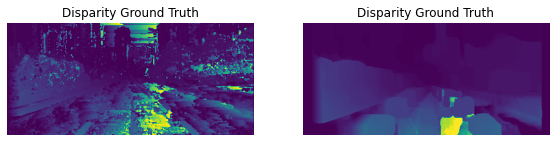

In [ ]:
ssd1 = matching_result(imgL, imgR, 3, "SSD", search=100, add_weight=0, subpixel=0)
ssd2 = matching_result(imgL, imgR, 30, "SSD", search=100, add_weight=0, subpixel=0)

plt.subplots(figsize=(15, 15)) 

plt.subplot(1,3,1)
plt.imshow(ssd1,cmap='viridis') 
plt.title('Disparity Ground Truth')
plt.axis('off')


plt.subplot(1,3,2)
plt.imshow(ssd2,cmap='viridis') 
plt.title('Disparity Ground Truth')
plt.axis('off')

#### get the best window size

In [ ]:
def select_best_wid(wid_range,matching):
    best_rms = 9999999
    best_disparity = np.zeros((imgL.shape[0], imgL.shape[1]))
    best_wid = 7
    # find the exact range
    for wid in wid_range:
        disparity= matching_result(imgL, imgR, wid, matching, search=100, add_weight=0, subpixel=0)
        if rms(disparity) < best_rms:
            best_rms = rms(disparity)
            best_disparity = disparity
            best_wid = wid
    return best_wid, best_disparity
    


In [ ]:
# select b/w 7,15,31,51,71 can be larger range heavy computation
wid_list = [7,15,31,51,71]
best_wid_ssd, ssd_disparity = select_best_wid(wid_list,"SSD")
print("The best widow size for SSD is", best_wid_ssd)
print("The cooresponding RMS for SSD is:", rms(ssd_disparity))
get_error_message(ssd_disparity-disparity_value,disparity_value)

best_wid_zssd, zssd_disparity = select_best_wid(wid_list,"ZSSD")
print("The best widow size for ZSSD is", best_wid_zssd)
print("The cooresponding RMS for ZSSD is:", rms(ssd_disparity))
get_error_message(zssd_disparity-disparity_value,disparity_value)

The best widow size for SSD is 15
The cooresponding RMS for SSD is: 16.048944712685035
fraction with error less than 4:  49.09%
fraction with error less than 2:  37.22%
fraction with error less than 1:  30.45%
fraction with error less than 0.5:  26.96%
fraction with error less than 0.25:  25.46%


#### Test Constraint performance

In [ ]:
### the performance of without constraints using different calculation method
SSD_disparity_simple = matching_result(imgL, imgR, 15, "SSD", search=100, add_weight=0, subpixel=0)
print("The RMS for SSD is:", rms(SSD_disparity_simple))
get_error_message(SSD_disparity_simple-disparity_value,disparity_value)


ZSSD_disparity_simple = matching_result(imgL, imgR, 15, "ZSSD", search=100, add_weight=0, subpixel=0)
print("The RMS for ZSSD is:", rms(ZSSD_disparity_simple))
get_error_message(ZSSD_disparity_simple-disparity_value,disparity_value)

ZNCC_disparity_simple = matching_result(imgL, imgR, 15, "ZNCC", search=100, add_weight=0, subpixel=0)
print("The RMS for ZNCC is:", rms(ZNCC_disparity_simple))
get_error_message(ZNCC_disparity_simple-disparity_value,disparity_value)

The RMS for SSD is: 16.048944712685035
fraction with error less than 4:  49.09%
fraction with error less than 2:  37.22%
fraction with error less than 1:  30.45%
fraction with error less than 0.5:  26.96%
fraction with error less than 0.25:  25.46%
The RMS for ZSSD is: 14.794080900924843
fraction with error less than 4:  49.48%
fraction with error less than 2:  37.43%
fraction with error less than 1:  30.71%
fraction with error less than 0.5:  27.22%
fraction with error less than 0.25:  25.67%
The RMS for ZNCC is: 13.973909101735925
fraction with error less than 4:  48.92%
fraction with error less than 2:  36.50%
fraction with error less than 1:  29.66%
fraction with error less than 0.5:  26.09%
fraction with error less than 0.25:  24.53%


In [ ]:
ssd_wid = 7
zssd_wid = 7
zncc_wid = 7

In [ ]:
start = time.time()
ssd_simple = matching_result(imgL, imgR, ssd_wid, "SSD", search=100, add_weight=0, subpixel=0)
end = time.time()
print("The execute time for accelaerate SSD is:", end-start,"secs")
print(rms(ssd_simple))
get_error_message(ssd_simple-disparity_value,disparity_value)

start = time.time()
ssd_weight = matching_result(imgL, imgR, ssd_wid, "SSD", search=100, add_weight=1, subpixel=0)
end = time.time()
print("The execute time for SSD with weight is:", end-start,"secs")
print(rms(ssd_weight))
get_error_message(ssd_weight-disparity_value,disparity_value)

start = time.time()
ssd = matching_result(imgL, imgR, ssd_wid, "SSD", search=100, add_weight=0, subpixel=0)
ssd_smooth = smooth(imgL, imgR, ssd_wid, ssd, "SSD", smooth_weight=0.5, search=100)
end = time.time()
print("The execute time for SSD with smooth constraint is:", end-start,"secs")
print(rms(ssd_smooth))
get_error_message(ssd_smooth-disparity_value,disparity_value)

start = time.time()
ssd_subpixel = matching_result(imgL, imgR, ssd_wid, "SSD", search=100, add_weight=0, subpixel=5)
end = time.time()
print("The execute time for SSD with subpixel accuracy is:", end-start,"secs")
print(rms(ssd_subpixel))
get_error_message(ssd_subpixel-disparity_value,disparity_value)

start = time.time()
ssd = matching_result(imgL, imgR, ssd_wid, "SSD", search=100, add_weight=1, subpixel=5)
ssd_all = smooth(imgL, imgR, ssd_wid, ssd, "SSD", smooth_weight=0.5, search=100)
end = time.time()
print("The execute time for SSD with smooth constraint+ weight + subpixel is:", end-start,"secs")
print(rms(ssd_all))
get_error_message(ssd_all-disparity_value,disparity_value)

The execute time for accelaerate SSD is: 57.401044607162476 secs
16.048944712685035
fraction with error less than 4:  49.09%
fraction with error less than 2:  37.22%
fraction with error less than 1:  30.45%
fraction with error less than 0.5:  26.96%
fraction with error less than 0.25:  25.46%
The execute time for SSD with weight is: 63.53096008300781 secs
17.801417847173184
fraction with error less than 4:  49.97%
fraction with error less than 2:  38.11%
fraction with error less than 1:  31.06%
fraction with error less than 0.5:  27.46%
fraction with error less than 0.25:  25.85%
The execute time for SSD with smooth constraint is: 276.4502749443054 secs
15.344559868337917
fraction with error less than 4:  60.46%
fraction with error less than 2:  50.98%
fraction with error less than 1:  45.40%
fraction with error less than 0.5:  42.53%
fraction with error less than 0.25:  41.31%


In [ ]:
start = time.time()
zssd = matching_result(imgL, imgR, zssd_wid, "ZSSD", search=100, add_weight=0, subpixel=0)
end = time.time()
print("The execute time for accelaerate ZSSD is:", end-start,"secs")
print(rms(zssd))
get_error_message(zssd-disparity_value,disparity_value)

start = time.time()
zssd_weight = matching_result(imgL, imgR, zssd_wid, "ZSSD", search=100, add_weight=1, subpixel=0)
end = time.time()
print("The execute time for ZSSD with weight is:", end-start,"secs")
print(rms(zssd_weight))
get_error_message(zssd_weight-disparity_value,disparity_value)

start = time.time()
zssd = matching_result(imgL, imgR, zssd_wid, "ZSSD", search=100, add_weight=0, subpixel=0)
zssd_smooth = smooth(imgL, imgR, zssd_wid, zssd, "ZSSD", smooth_weight=0.5, search=100)
end = time.time()
print("The execute time for ZSSD with smooth constraint is:", end-start,"secs")
print(rms(zssd_smooth))
get_error_message(zssd_smooth-disparity_value,disparity_value)


start = time.time()
ssd_subpixel = matching_result(imgL, imgR, zssd_wid, "ZSSD", search=100, add_weight=0, subpixel=5)
end = time.time()
print("The execute time for ZSSD with subpixel accuracy is:", end-start,"secs")
print(rms(ssd_subpixel))
get_error_message(ssd_subpixel-disparity_value,disparity_value)

start = time.time()
zssd = matching_result(imgL, imgR, zssd_wid, "ZSSD", search=100, add_weight=1, subpixel=5)
zssd_all = smooth(imgL, imgR, zssd_wid, zssd, "ZSSD", smooth_weight=0.5, search=100)
end = time.time()
print("The execute time for ZSSD with smooth constraint+ weight + subpixel is:", end-start,"secs")
print(rms(zssd_all))
get_error_message(zssd_all-disparity_value,disparity_value)